<a id="table"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table of Contents</h1>

[1. Notebook Versions](#1)

[2. Loading Libraries](#2)

[3. Reading Data Files](#3)

[4. Data Exploration](#4)

[5. Baseline Modeling 1.0](#5)

<a id="1"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Notebook Versions</h1>

1. Version 1 (07/10/2023)
    * EDA 
    * Baseline modeling 1.0
    
<a id="2"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Loading Libraries</h1>    

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold, GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
# from sklego.linear_model import LADRegression

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<a id="3"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Reading Data Files</h1> 

In [2]:
train = pd.read_csv('../input/playground-series-s3e19/train.csv')
train['date'] = pd.to_datetime(train['date'])

test = pd.read_csv('../input/playground-series-s3e19/test.csv')
test['date'] = pd.to_datetime(test['date'])

submission = pd.read_csv('../input/playground-series-s3e19/sample_submission.csv')
submission.columns = ['id', 'num_sold']

print('The dimension of the train synthetic dataset is:', train.shape)
print('The dimension of the test synthetic dataset is:', test.shape)
print('The dimension of the submission dataset is:', submission.shape)

The dimension of the train synthetic dataset is: (136950, 6)
The dimension of the test synthetic dataset is: (27375, 5)
The dimension of the submission dataset is: (27375, 2)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        136950 non-null  int64         
 1   date      136950 non-null  datetime64[ns]
 2   country   136950 non-null  object        
 3   store     136950 non-null  object        
 4   product   136950 non-null  object        
 5   num_sold  136950 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 6.3+ MB


In [4]:
train.head()

id       date    country         store  \
0   0 2017-01-01  Argentina  Kaggle Learn   
1   1 2017-01-01  Argentina  Kaggle Learn   
2   2 2017-01-01  Argentina  Kaggle Learn   
3   3 2017-01-01  Argentina  Kaggle Learn   
4   4 2017-01-01  Argentina  Kaggle Learn   

                                          product  num_sold  
0               Using LLMs to Improve Your Coding        63  
1                   Using LLMs to Train More LLMs        66  
2  Using LLMs to Win Friends and Influence People         9  
3      Using LLMs to Win More Kaggle Competitions        59  
4                      Using LLMs to Write Better        49

In [5]:
test.head()

id       date    country         store  \
0  136950 2022-01-01  Argentina  Kaggle Learn   
1  136951 2022-01-01  Argentina  Kaggle Learn   
2  136952 2022-01-01  Argentina  Kaggle Learn   
3  136953 2022-01-01  Argentina  Kaggle Learn   
4  136954 2022-01-01  Argentina  Kaggle Learn   

                                          product  
0               Using LLMs to Improve Your Coding  
1                   Using LLMs to Train More LLMs  
2  Using LLMs to Win Friends and Influence People  
3      Using LLMs to Win More Kaggle Competitions  
4                      Using LLMs to Write Better

<a id="4"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Exploration</h1>

First, we start by visualizing `num_sold` by `product` and `country`.

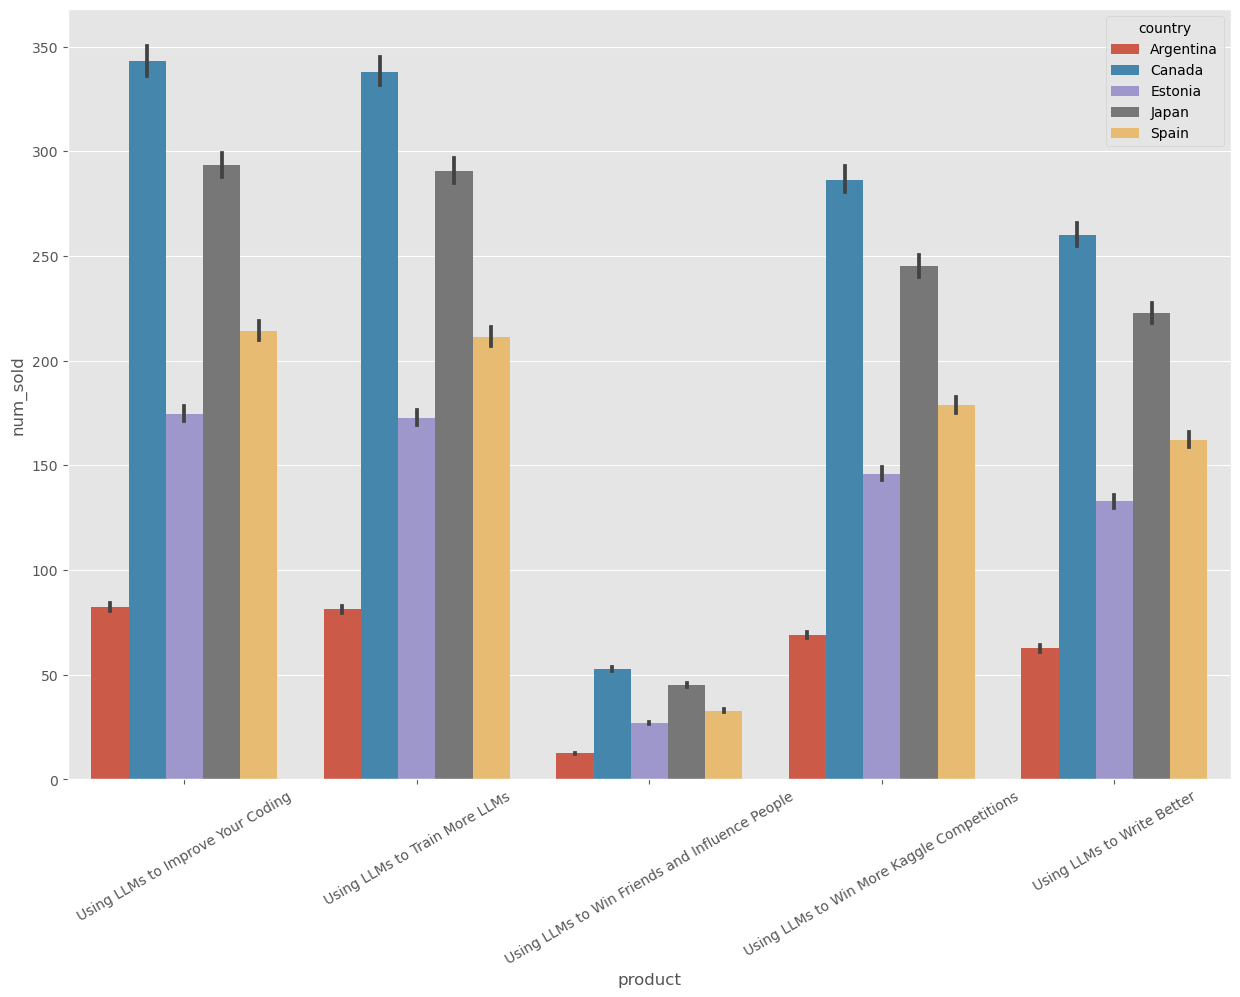

In [6]:
plt.figure(figsize = (15, 10))

ax = sns.barplot(data = train, x = 'product', y = 'num_sold', hue = 'country')
plt.xticks(rotation = 30);

From the above, we see the following:

- All products are sold in all the countries.
- `Using LLMs to Improve Your Coding` is the most sold product across the countries.
- `Using LLMS to Win Friends and Influence People` is the least sold product across the countries.
- `Canada` is the country with the highest sales.
- `Argentina` is the country with the least sales.

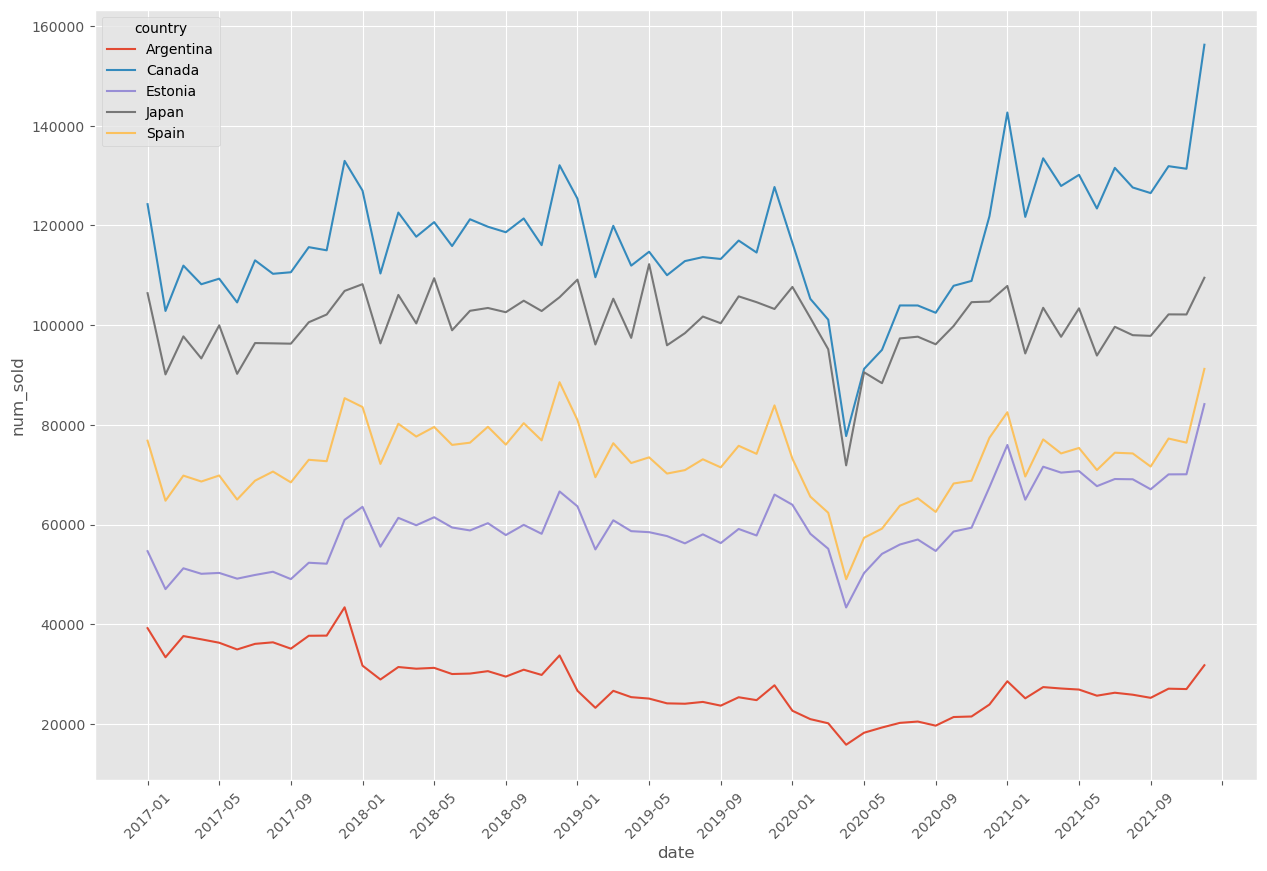

In [7]:
plt.figure(figsize = (15, 10))

ax = sns.lineplot(data = train.groupby([train.date.dt.strftime('%Y-%m'), train.country])['num_sold'].sum().reset_index(),
                  x = 'date',
                  y = 'num_sold',
                  hue ='country')

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20))
plt.xticks(rotation = 45);

From the above, we see that all the countries experience a significant decrease in sales in March and April of 2020 due to the pandemic.

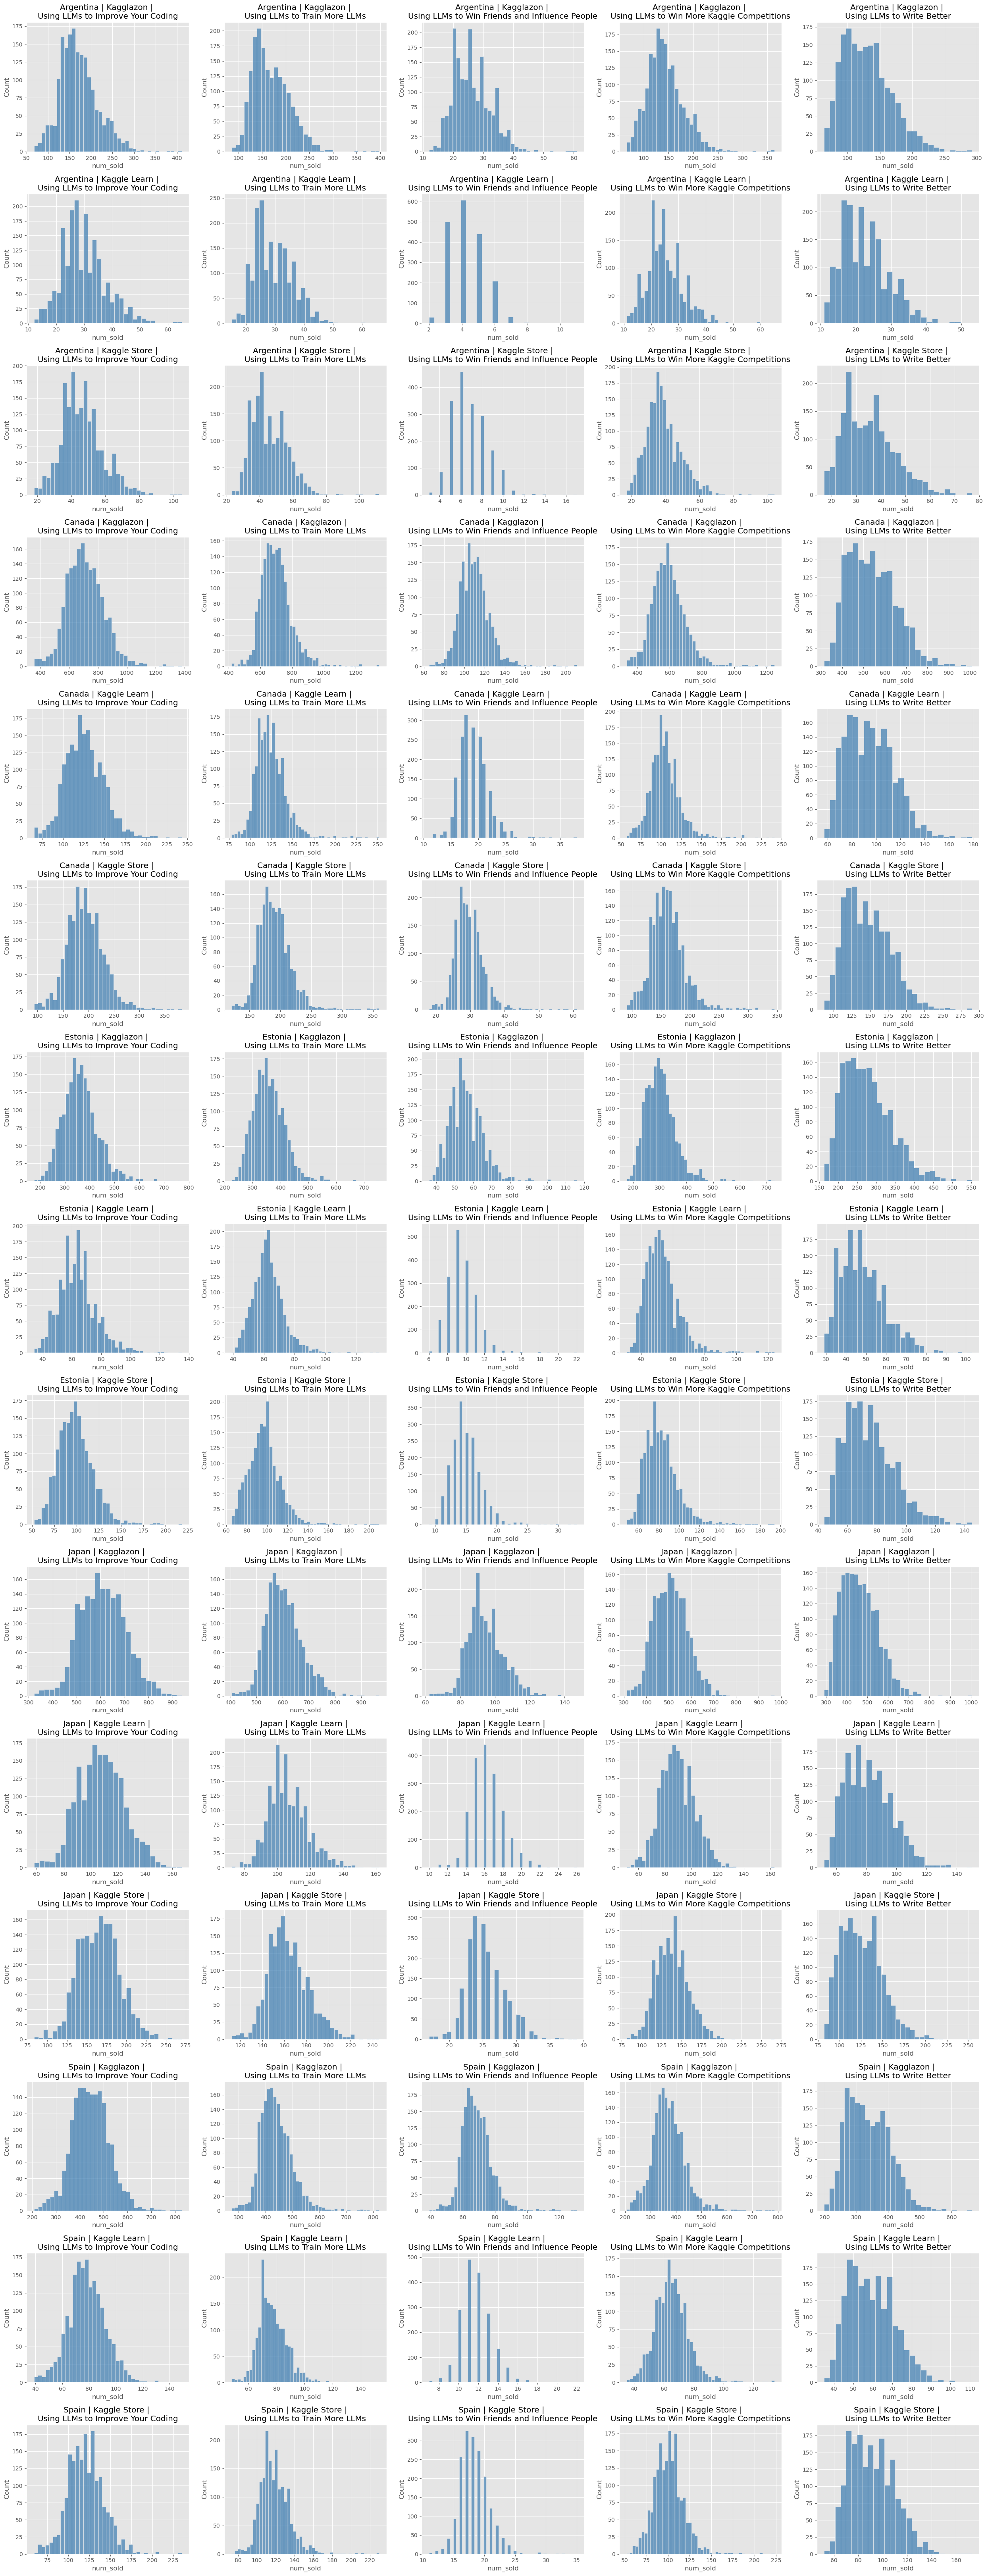

In [8]:
fig, ax = plt.subplots(15, 5, figsize = (25, 65))
ax = ax.flatten()

for i, (combination, df) in enumerate(train.groupby(['country', 'store', 'product'])):
    sns.histplot(df.num_sold, ax = ax[i], color = 'steelblue')
    ax[i].set_title(combination[0] + ' | ' + combination[1] +  ' | ' + '\n' + combination[2])

plt.tight_layout()

From the above we see that most of the distributions are right-skewed.

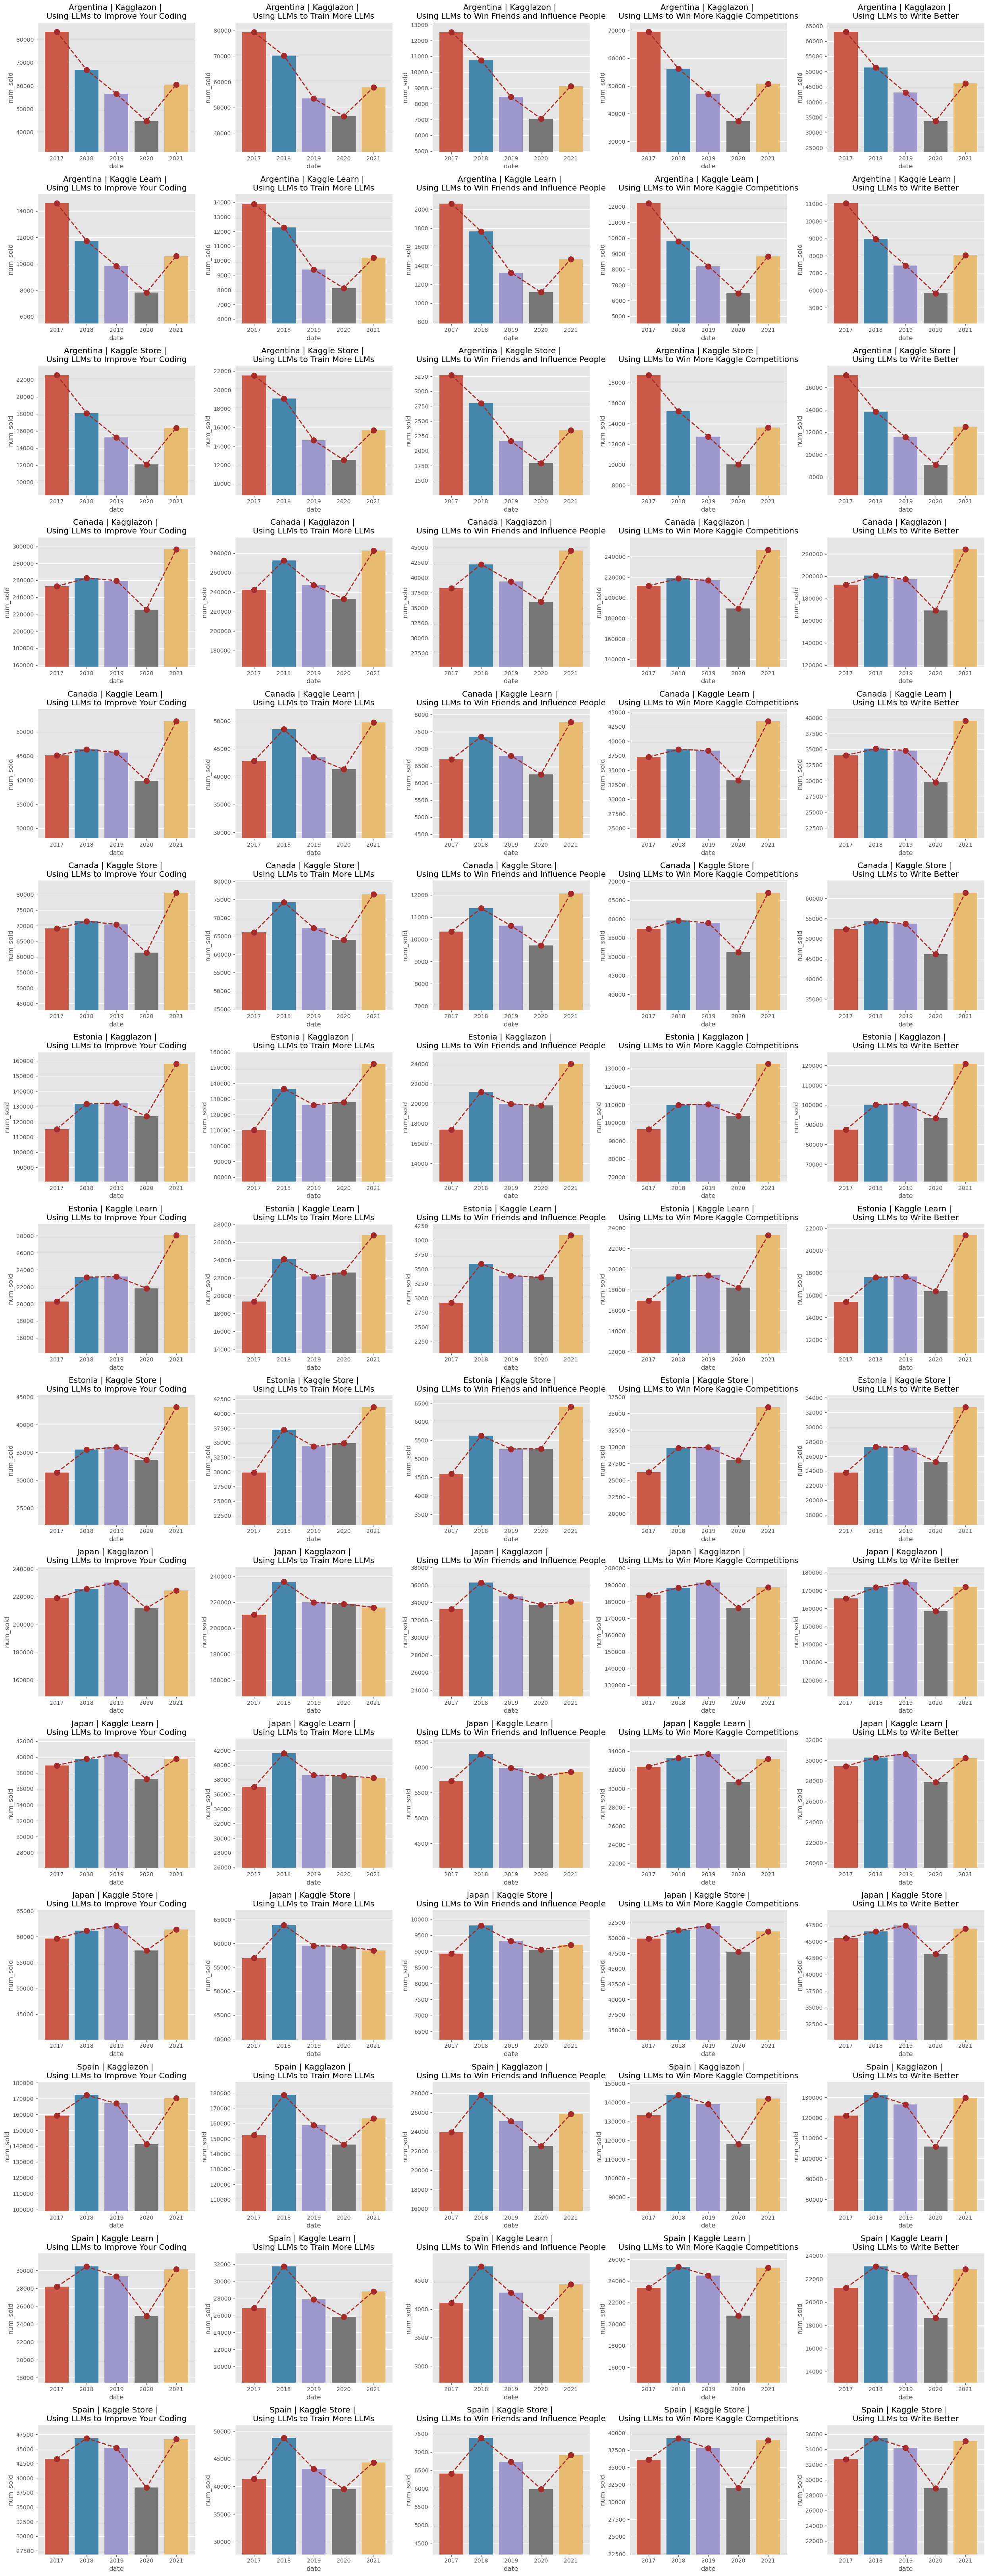

In [9]:
fig, ax = plt.subplots(15, 5, figsize = (25, 65))
ax = ax.flatten()
for i, (combination, df) in enumerate(train.groupby(['country', 'store', 'product'])):
    data = df.groupby(df.date.dt.year)['num_sold'].sum().reset_index()
    sns.barplot(data = data, x = 'date', y = 'num_sold', ax = ax[i])
    ax[i].plot(ax[i].get_xticks(), data.num_sold,
               color = 'brown', linestyle = '--', marker = '.',
               markersize = 20, linewidth = 2
    )
    lims = ax[i].get_ylim()
    ax[i].set_ylim(data.num_sold.min()*0.7, lims[1])
    ax[i].set_title(combination[0] + ' | ' + combination[1] +  ' | ' + '\n' + combination[2])
plt.tight_layout()

From the above, we can see in most countries there is a significant increase in `num_sold` from 2020 to 2021.

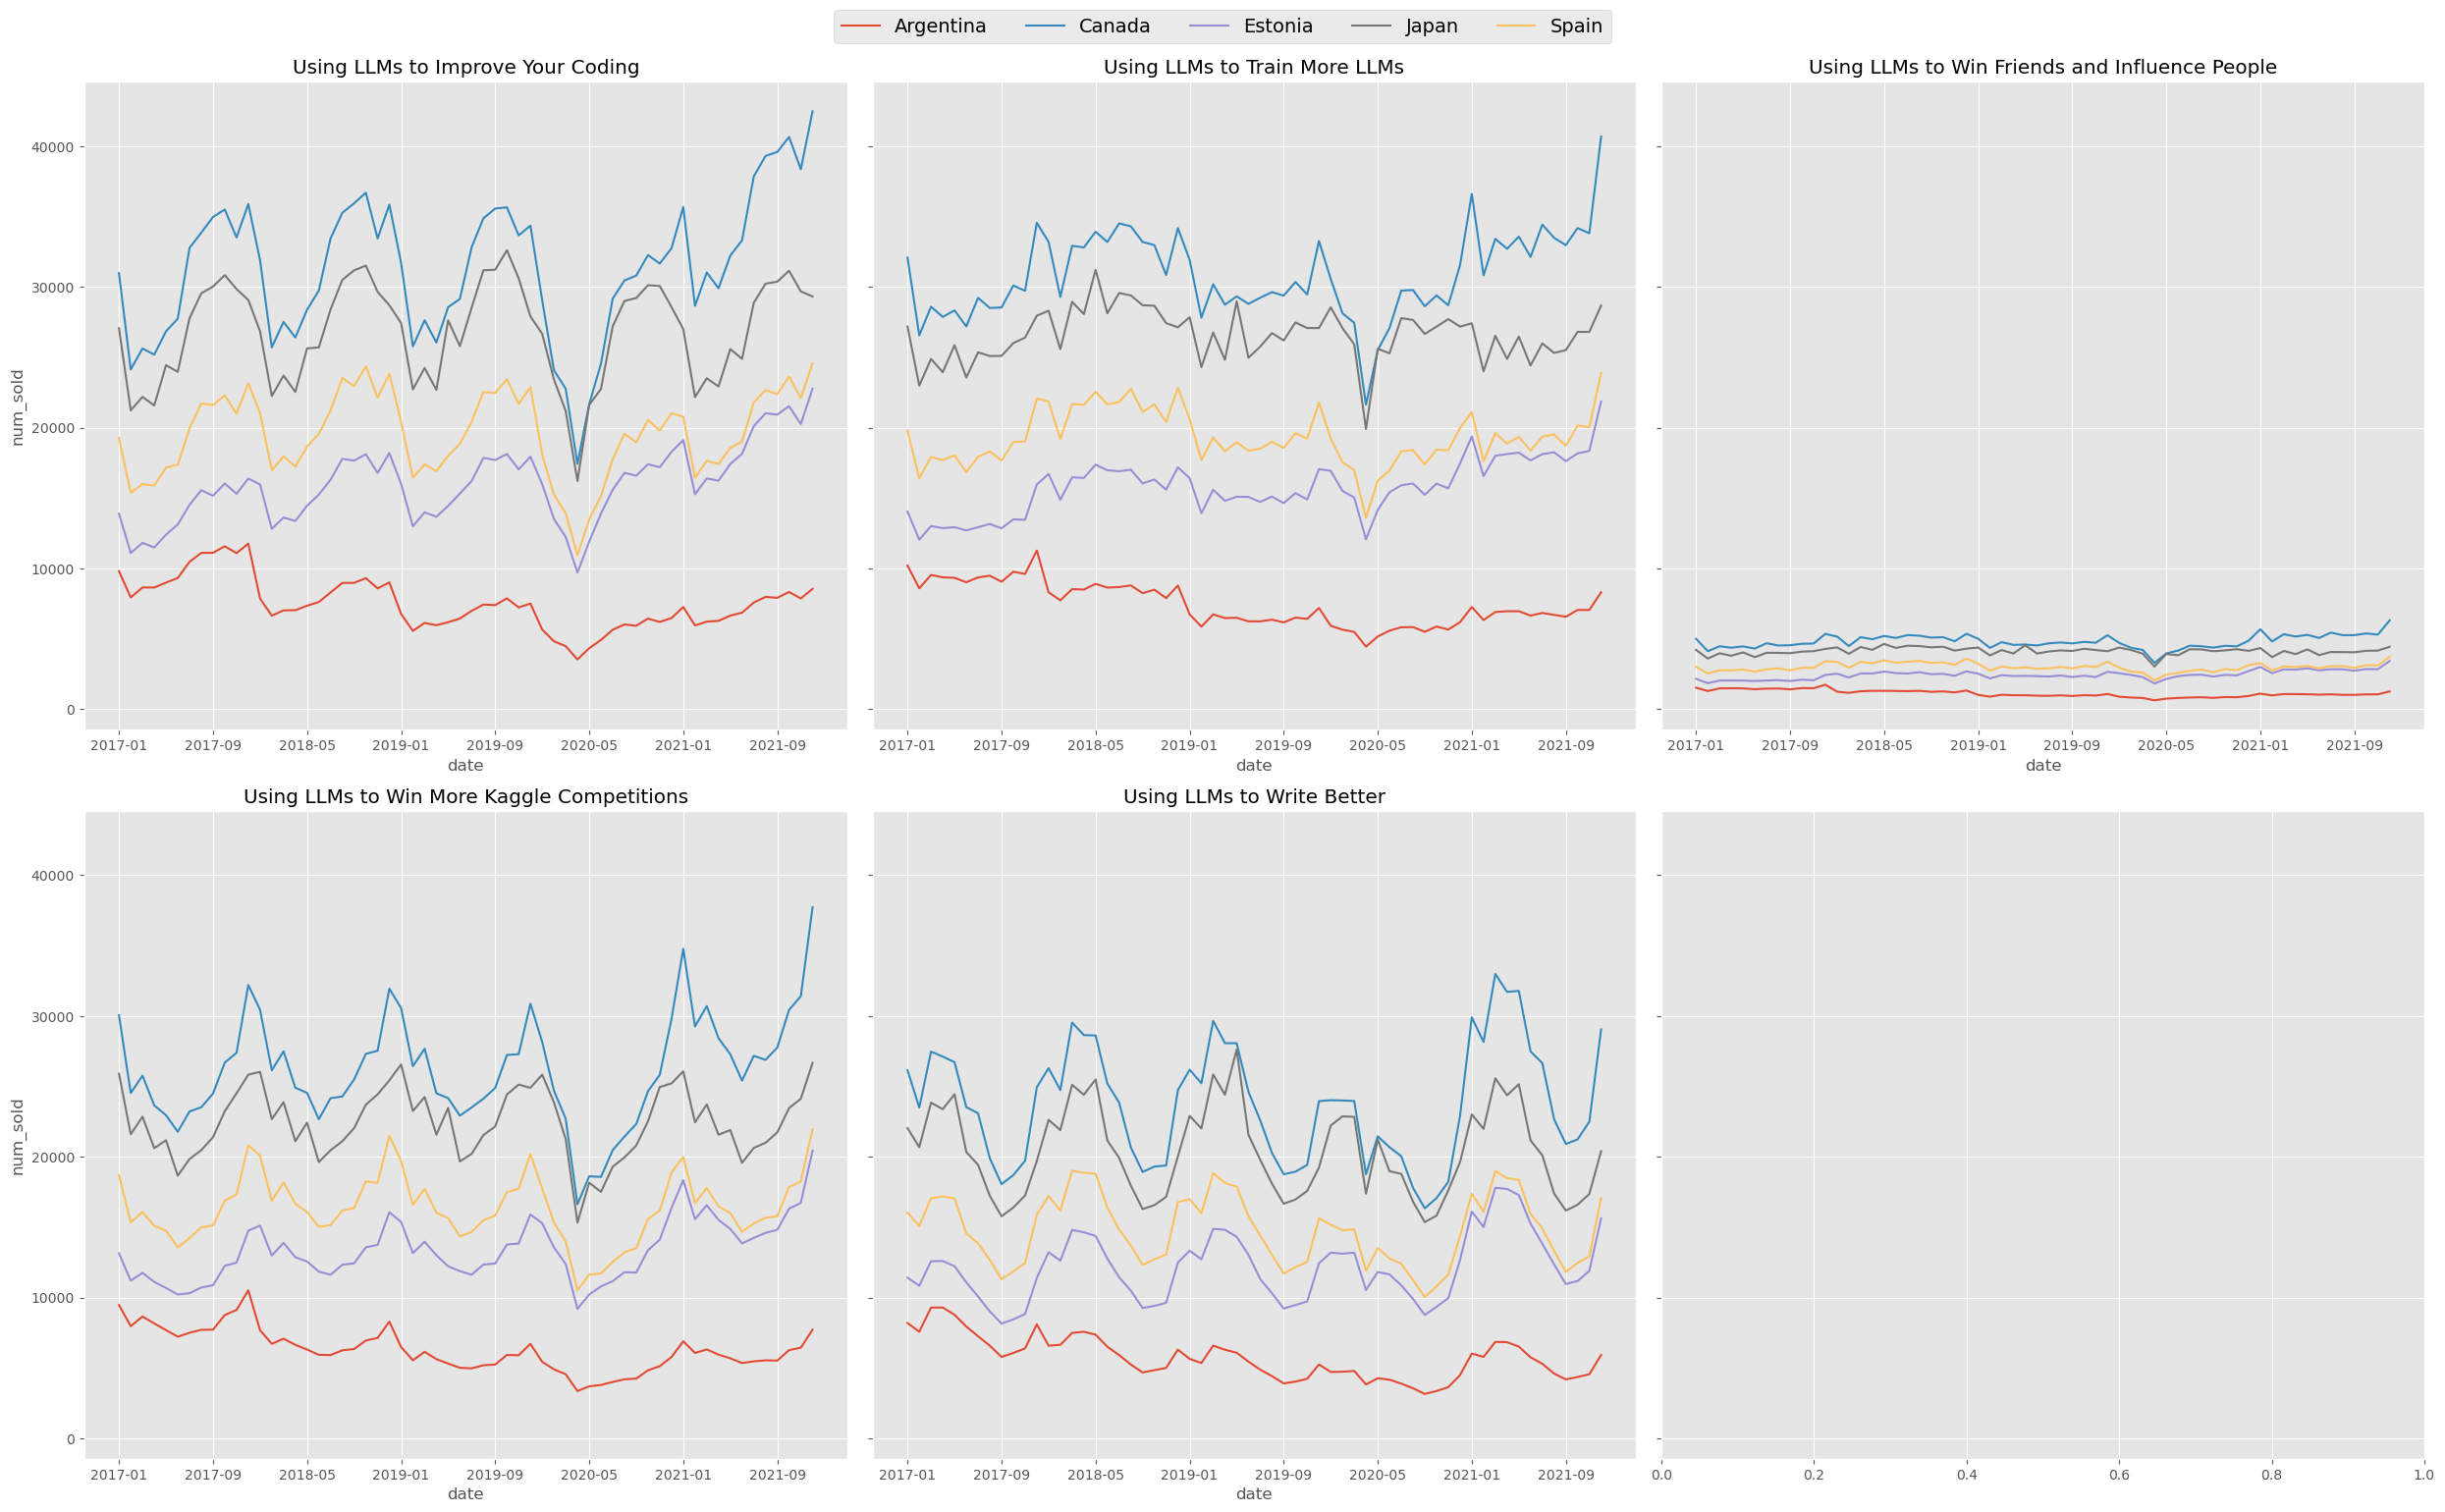

In [10]:
fig, ax = plt.subplots(2, 3, figsize = (25, 15), sharey = True)
ax = ax.flatten()
hue_order = train.country.unique()

for i, product in enumerate(train['product'].unique()):
    df = train[train['product'] == product]
    sns.lineplot(data = df.groupby([df.date.dt.strftime('%Y-%m'), df.country])['num_sold'].sum().reset_index(),
                 x = 'date',
                 y = 'num_sold',
                 hue = 'country',
                 ax = ax[i],
                 hue_order = hue_order
    )
    ax[i].set_title(product)
    ax[i].xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
    
    handles = ax[i].get_legend_handles_labels()[0]
    labels = ax[i].get_legend_handles_labels()[1]
    ax[i].legend().remove()
    
fig.legend(handles, labels, loc = 'upper center', bbox_to_anchor=(0.5, 1.03), fontsize = 14, ncol = 6)
plt.tight_layout()

From the above, we see:

- The difference in `num_sold` across the countries is clear.
- It seems that there is a monthly seasonality in `num_sold`.

<a id="5"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 1.0</h1>


In [11]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

def feature_engineer(df):
    
    new_df = df.copy()
    new_df["month"] = df["date"].dt.month
    new_df["month_sin"] = np.sin(new_df['month'] * (2 * np.pi / 12))
    new_df["month_cos"] = np.cos(new_df['month'] * (2 * np.pi / 12))
    
    new_df["day"] = df["date"].dt.day
    new_df["day_sin"] = np.sin(new_df['day'] * (2 * np.pi / 12))
    new_df["day_cos"] = np.cos(new_df['day'] * (2 * np.pi / 12))
    
    new_df["day_of_week"] = df["date"].dt.dayofweek
    new_df["day_of_week"] = new_df["day_of_week"].apply(lambda x: 0 if x <= 3 else(1 if x == 4 else (2 if x == 5 else (3))))
    
    new_df["day_of_year"] = df["date"].dt.dayofyear
    new_df["year"] = df["date"].dt.year
    
    return new_df

train = feature_engineer(train)
test = feature_engineer(test)

In [12]:
X = train.drop(columns = ['id', 'date', 'country', 'store', 'product', 'num_sold'], axis = 1)
Y = train['num_sold']

test_baseline = test.drop(columns = ['id', 'date', 'country', 'store', 'product'], axis = 1)

linear_preds = np.zeros(test.shape[0])
linear_smape = 0

ridge_preds = np.zeros(test.shape[0])
ridge_smape = 0

lasso_preds = np.zeros(test.shape[0])
lasso_smape = 0

elastic_preds = np.zeros(test.shape[0])
elastic_smape = 0

kf = GroupKFold(n_splits = 5)

for trn_idx, test_idx in kf.split(X, groups = X.year):
    
    x_train, x_valid = X.iloc[trn_idx], X.iloc[test_idx]
    y_train, y_valid = Y.iloc[trn_idx], Y.iloc[test_idx]
    
    ##################
    ## Linear model ##
    ##################
    
    linear_model = LinearRegression().fit(x_train, y_train)

    y_pred = linear_model.predict(x_valid)
    linear_smape += smape(y_valid, y_pred) / kf.n_splits
    
    linear_pred = linear_model.predict(test_baseline)
    linear_pred = pd.Series(linear_pred) 
    linear_preds += linear_pred / kf.n_splits
    
    ###########
    ## Ridge ##
    ###########
    
    ridge_model = Ridge(alpha = 0.0999, tol = 1e-2, max_iter = 1000000, random_state = 42).fit(x_train, y_train)

    y_pred = ridge_model.predict(x_valid)
    ridge_smape += smape(y_valid, y_pred) / kf.n_splits
    
    ridge_pred = ridge_model.predict(test_baseline)
    ridge_pred = pd.Series(ridge_pred) 
    ridge_preds += ridge_pred / kf.n_splits
    
    ###########
    ## Lasso ##
    ###########
    
    lasso_model = Lasso(alpha = 0.0999, tol = 1e-2, max_iter = 1000000, random_state = 42).fit(x_train, y_train)

    y_pred = lasso_model.predict(x_valid)
    lasso_smape += smape(y_valid, y_pred) / kf.n_splits
    
    lasso_pred = lasso_model.predict(test_baseline)
    lasso_pred = pd.Series(lasso_pred) 
    lasso_preds += lasso_pred / kf.n_splits
    
    #############
    ## Elastic ##
    #############
    
    elastic_model = ElasticNet(alpha = 0.0002, l1_ratio = 0.001, random_state = 42).fit(x_train, y_train)

    y_pred = elastic_model.predict(x_valid)
    elastic_smape += smape(y_valid, y_pred) / kf.n_splits
    
    elastic_pred = elastic_model.predict(test_baseline)
    elastic_pred = pd.Series(elastic_pred) 
    elastic_preds += elastic_pred / kf.n_splits

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.906e+09, tolerance: 3.834e+05
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.757e+09, tolerance: 3.536e+05
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.837e+09, tolerance: 3.695e

We next proceed to compare model performance.

In [13]:
md_perf = pd.DataFrame({'Model': ['Linear', 'Ridge', 'Lasso', 'Elastic'], 
                        'CV-Score': [linear_smape, ridge_smape, lasso_smape, elastic_smape]})
md_perf

Model   CV-Score
0   Linear  84.596858
1    Ridge  84.595791
2    Lasso  84.285078
3  Elastic  84.271386

In [14]:
w1 = 1/ linear_smape
w2 = 1/ ridge_smape
w3 = 1/ lasso_smape
w4 = 1/ elastic_smape
wtot = w1 + w2 + w3 + w4

w1 = w1 / wtot
w2 = w2 / wtot
w3 = w3 / wtot
w4 = w4 / wtot

submission['num_sold'] = linear_preds * w1 + ridge_preds * w2 + lasso_preds * w3  + elastic_preds * w4
submission.head()

id    num_sold
0  136950  184.372583
1  136951  184.372583
2  136952  184.372583
3  136953  184.372583
4  136954  184.372583

In [15]:
submission.to_csv('Baseline_submission.csv', index = False)